# Searchlight analysis

### 필요한 것
  * X = dataset. nilearn.image
  * y = target. list 또는 np.array (list-like object)
  * group = 각 timepoint 별로, cross-validation 에 쓰일 데이터의 group 인덱스. 
  
### estimator 의 선택
  * MVPA 의 경우 classifier 로 자주 쓰는 것은 LDA 나 LinearSVC
  * LDA 의 경우 `LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')` 옵션을 쓰면 좀 느리지만 더 정확함
      * https://scikit-learn.org/stable/modules/lda_qda.html#shrinkage
  * `LinearSVC` 의 경우 max_iter 를 올리는 것을 고려하자
      * 개인적으로는 ROI analysis 에는 max_iter=50000, searchlight analysis 에는 10000 정도..
  
### cv 의 선택
  * cross-validation 의 옵션은 leave one-run out cross-validation (loocv) 이 되도록,
      * https://www.slideshare.net/EmilyYunhaShin/20190312-pitfalls
      * within run 으로 돌리게 될 경우 accuracy 가 inflated 될 가능성이 높음.
  * group 값, cv k 값, cv 를 `GroupKFold` 를 사용하도록 설정하자
  * `GroupKFold` 를 명시적으로 넣어주지 않는 경우 group 값과 k 값을 넣어주어도 이를 반영하지 않고 데이터셋을 k 개로 split 해서 사용하는 코드들이 많이 있음
  
### Searchlight 의 radius
  * 작게는 6mm, 크게는 12mm?
  * (경험상) 관심으로 두고 있는 영역이 어딘지에 따라 달라질 수 있다.
      * subcortical 의 작은 영역들을 주로 보려고 한다 = 작은 radius 사용
      * cortex 혹은 exploratory 하게 보려는 경우에는 8~9mm 사용하면 괜찮은 듯
  * 선행 논문을 참고하는 것도 좋음
  * image 의 resolution
      * voxel 이 크다면 radius 가 크더라도 몇 복셀 안 들어갈 수 있으므로 참고함
  * processing 시간
      * radius 가 크면 클수록 오래 걸린다.
  * https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3988828/

In [28]:
# import 문
import nilearn.image, nilearn.decoding

import numpy as np
import pandas as pd

from sklearn.svm import LinearSVC
from sklearn.model_selection import GroupKFold

/Users/eyshin/.pyenv/versions/eyspy3.6/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)


In [9]:
# def get_behavior_data(subj, run, target):
#     behav_df = pd.read_csv('%s/%s_behav.csv' % (behav_dir, subj), index_col=0)
#     behav_df = behav_df[behav_df['run'] == run]
#     #behav_df = behav_df[behav_df['valid']]

#     labels = behav_df.loc[:, ['run', 'order', 'group', 'valid']]

#     if target == 'move':
#         mapping = {'down': 1, 'mid': 2, 'up': 3}
#         labels['task_type'] = [mapping[a] for a in behav_df['answer']]
#     elif target == 'plan':
#         mapping = {30: 1, 0: 2, -30: 3}
#         labels['task_type'] = [mapping[int(a)] for a in behav_df['rotate_type']]
#     elif target == 'position':
#         mapping = {'high': 1, 'middle': 2, 'low': 3}
#         labels['task_type'] = [mapping[a] for a in behav_df['target_position']]
#     elif target == 'color':
#         labels['task_type'] = behav_df['color_type'].copy()
#     else:
#         raise ValueError()

#     return labels

In [24]:
def load_beta_image(subj, run):
    # load nilearn image
    # nii.gz 추천. HEAD/BRIK 은 load 안 되는 것 같음.
    
    # example
    #img = nilearn.image.load_img(data_dir + 'coef.%s.r0%d.nii.gz' % (subj, run))
    #return img
    
    pass


def load_target(subj, run):
    # load behavior data and make up them
    
    # example
    #labels = get_behavior_data(subj, run, 'move')
    #return list(labels['task_type'])
    
    pass


def get_X_y_group(subj, runs):
    Xs = [
        load_beta_image(subj, run)
        for run in runs
    ]
    
    ys = [
        load_target(subj, run)
        for run in runs
    ]
    
    group = [
        i for i, y in enumerate(ys) for j in range(len(y))
    ]
    
    Xs = nilearn.image.concat_imgs(Xs)
    ys = np.concatenate(ys)
    
    assert Xs.shape[-1] == ys.shape[0]
    assert ys.shape[0] == len(group)
    
    return Xs, ys, group

In [26]:
def run_searchlight(full_mask, X, y, group, estimator, group_k, radius, chance_level):
    cv = GroupKFold(group_k)

    searchlight = nilearn.decoding.SearchLight(
        full_mask,
        radius=radius,
        estimator=estimator,
        n_jobs=4,
        verbose=False,
        cv=cv,
        scoring='balanced_accuracy'
    )

    searchlight.fit(X, y, group)
    scores = searchlight.scores_ - chance_level

    return nilearn.image.new_img_like(full_mask, scores)

In [36]:
# example

data_dir = '/Volumes/clmnlab/IN/MVPA/LSS_trialtypes_pb04/03_data/'
behav_dir = '/Volumes/clmnlab/IN/new_label/01_behav/'

estimator = LinearSVC(max_iter=10000)
estimator_name = 'svc'
radius = 1  # 적절한 크기를 사용하세요.

# full mask 를 사용하시면 됩니다. 여기에서는 processing time 줄이려고 작은 마스크 가져옴.
mask_img = nilearn.image.load_img('/Volumes/clmnlab/IN/new_label/04_ROIs/cb8.nii.gz')

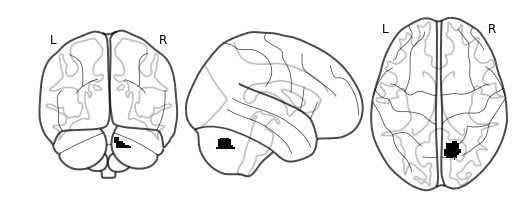

In [38]:
import nilearn.plotting
import matplotlib.pyplot as plt

nilearn.plotting.plot_glass_brain(mask_img)
plt.show()

In [32]:
X, y, group = get_X_y_group('IN04', [3, 5])

In [39]:
searchlight_img = run_searchlight(mask_img, X, y, group, group_k=2,
                                  estimator=estimator, radius=radius, chance_level=1/2)

In [42]:
searchlight_img.to_filename('%s_r%d_%s.nii.gz' % ('IN04', radius, estimator_name))